In [1]:
import pandas as pd
import numpy as np
import sys, zipfile, os, time
import matplotlib
import matplotlib.pyplot as plt
import glob
import datetime
import urllib3
import cdsapi
import xarray
import shutil
import warnings
import pickle
import h5py
import netCDF4
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua


In [2]:
def get_adj(station, tarvar):
    import datetime
    if tarvar == 'directionbias':
        cdsvar = 'wind_direction'
    elif tarvar == 'uwindbias':
        cdsvar = 'u_component_of_wind'
    elif tarvar == 'vwindbias':
        cdsvar = 'v_component_of_wind'
    else:
        print('not an available wind variable')
        return 0, 0, 0, 0, 0
    """Compare created adjustment to downloaded adjustment
    """
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")

    file = glob.glob('./Wind_adjustment/*/*winddir*'+station+'*')[0]
    data = eua.CDMDataset(file)#.to_dataframe()
    display(data)
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")

    lessdates = []
    basedatum = data.datum[:]
    for i in range(basedatum[0], basedatum[-1], 1000):
        lessdates.append(date0 + datetime.timedelta(days=int(i)))
    dates = lessdates
    
    press = data.press[:]
    print(press)
    nightadj = data[tarvar][0,:]
    dayadj = data[tarvar][1,:]    
    
    c = cdsapi.Client()
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {'variable': cdsvar,
                    'optional':['wind_bias_estimate'],
                    'statid': station,
                    'skip':'8',
                    'pressure_level':[10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]
                   }
                  )
    r.download(target='download.zip')
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./tocompare/wind/cds_'+station)
    z.close()
    cdsfile = glob.glob('./tocompare/wind/cds_'+ station +'/*.nc')
    cdsdata=eua.CDMDataset(cdsfile[0]).to_dataframe()
    daycdsdata = cdsdata[cdsdata.time.dt.hour > 6][cdsdata.time.dt.hour <= 18]
    nightcdsdata = cdsdata[cdsdata.time.dt.hour <= 6].append(cdsdata[cdsdata.time.dt.hour > 18])
    
    
    calc_day_out = {}
    calc_night_out = {}
    cds_day_out = {}
    cds_night_out = {}
    for i in [10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]:
        calc_day_out[str(i)]=[]
        calc_night_out[str(i)]=[]
        cds_day_out[str(i)]=[]
        cds_night_out[str(i)]=[]
        
    for i in range(len(dates)-1):
        for j in range(len(press)):
            try:
                d_adjd = dayadj[j][i*300]
                calc_day_out[str(int(press[j]))].append(d_adjd)
            except:
                calc_day_out[str(int(press[j]))].append(np.nan) 
            try:
                d_cdsd = daycdsdata[daycdsdata.plev == press[j]*100][daycdsdata.time >= dates[i]][daycdsdata.time < dates[i+1]]
                cds_day_out[str(int(press[j]))].append(d_cdsd['wind_bias_estimate'].iloc[0])
            except:
                cds_day_out[str(int(press[j]))].append(np.nan)
            try:
                n_cdsd = nightcdsdata[nightcdsdata.plev == press[j]*100][nightcdsdata.time >= dates[i]][nightcdsdata.time < dates[i+1]]
                cds_night_out[str(int(press[j]))].append(n_cdsd['wind_bias_estimate'].iloc[0])
            except:
                cds_night_out[str(int(press[j]))].append(np.nan)
            try:
                n_adjd = nightadj[j][i*300]
                calc_night_out[str(int(press[j]))].append(n_adjd)
            except:
                calc_night_out[str(int(press[j]))].append(np.nan)
                
    return dates, cds_day_out, cds_night_out, calc_day_out, calc_night_out

In [3]:
def plt_adj(dates, cdata, adata, plev, station, time, adj, save):
#     dates_list = [datetime.datetime.strptime(date, '%Y%m%d').date() for date in dates[1:]]
    fig, ax = plt.subplots()
    if not np.isnan(cdata[str(plev)]).all():
        ax.scatter(dates[1:], np.asarray(cdata[str(plev)]), label='CDS', s=50)
    if not np.isnan(adata[str(plev)]).all():
        ax.scatter(dates[1:], np.asarray(adata[str(plev)]), label='Calc', s=20)
    ax.set(xlabel='time', ylabel='Adjustment: '+adj,
           title= str(station)+' Wind '+str(plev)+' hPa '+time)
    ax.legend()
    ax.grid()
    
    if save:
        fig.savefig(str(station)+'_Wind_'+str(plev)+'_hPa_'+time+'.png')
    plt.show()
    return

File: <HDF5 file "feedbackmergedwinddir068994.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 14.61 MB
Filename: ./Wind_adjustment/068994/feedbackmergedwinddir068994.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 19609)
 - V | datum________________________________________ : : (19609,)
 - V | directionbias________________________________ : : (2, 16, 19609)
 - V | era5_fgdep___________________________________ : : (2, 16, 19609)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 19609)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (19609,)
 - V | uwindb

[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:38:58,362 INFO Welcome to the CDS
2021-05-06 08:38:58,363 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 08:38:58,901 INFO Request is completed
2021-05-06 08:38:58,903 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620282764.4929628-32492-1-0156159c-f549-4cfc-883c-49d112324d81.zip to download.zip (10.5M)
2021-05-06 08:39:00,852 INFO Download rate 5.4M/s   
2021-05-06 08:39:01,063 INFO Reading Profile on slice(None, None, None)
2021-05-06 08:39:03,371 INFO Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-05-06 08:39:03,372 INFO NumExpr defaulting to 8 threads.


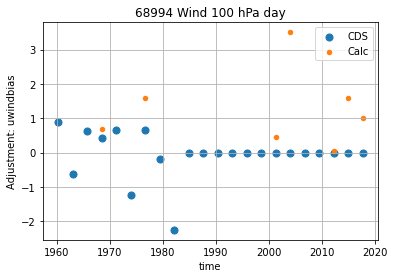

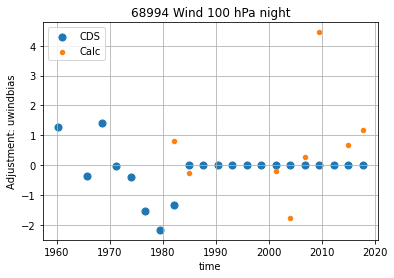

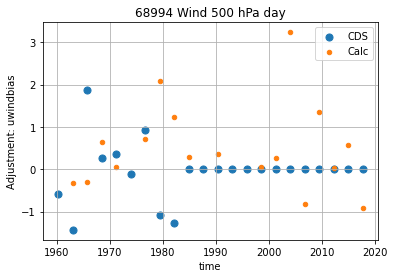

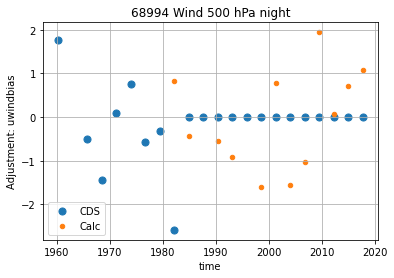

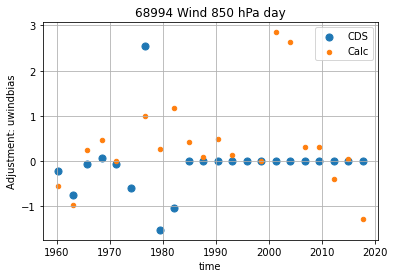

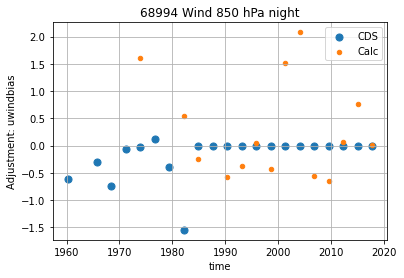

In [4]:
station = '68994'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir068994.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 14.61 MB
Filename: ./Wind_adjustment/068994/feedbackmergedwinddir068994.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 19609)
 - V | datum________________________________________ : : (19609,)
 - V | directionbias________________________________ : : (2, 16, 19609)
 - V | era5_fgdep___________________________________ : : (2, 16, 19609)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 19609)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (19609,)
 - V | uwindb

2021-05-06 08:39:58,477 INFO Welcome to the CDS
2021-05-06 08:39:58,478 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:39:58,851 INFO Request is completed
2021-05-06 08:39:58,852 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620282784.1507347-32678-1-ae5416e5-f4e4-48cd-bbc7-ae2f3411be86.zip to download.zip (10.6M)
2021-05-06 08:40:00,884 INFO Download rate 5.2M/s   
2021-05-06 08:40:01,042 INFO Reading Profile on slice(None, None, None)


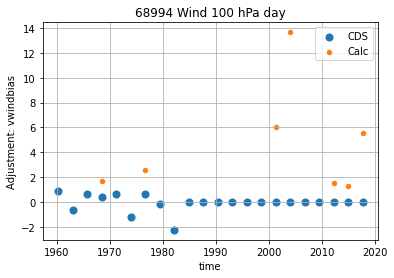

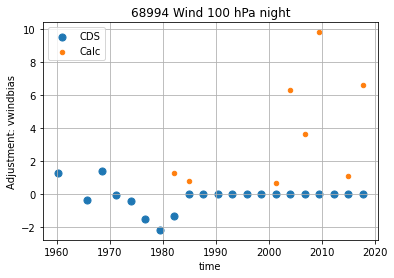

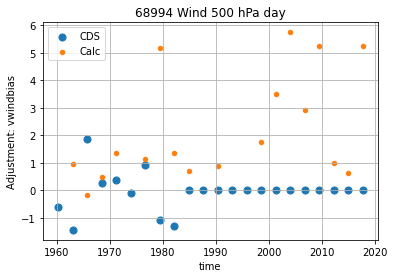

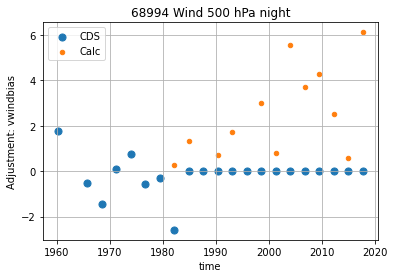

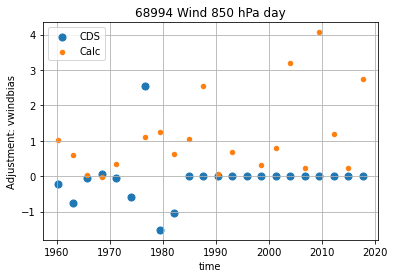

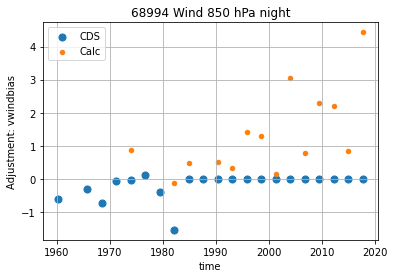

In [5]:
station = '68994'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir068994.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 14.61 MB
Filename: ./Wind_adjustment/068994/feedbackmergedwinddir068994.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 19609)
 - V | datum________________________________________ : : (19609,)
 - V | directionbias________________________________ : : (2, 16, 19609)
 - V | era5_fgdep___________________________________ : : (2, 16, 19609)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 19609)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (19609,)
 - V | uwindb

2021-05-06 08:40:21,647 INFO Welcome to the CDS
2021-05-06 08:40:21,649 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:40:21,908 INFO Request is completed
2021-05-06 08:40:21,910 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620282805.4685836-32634-1-c0f5645e-0934-443a-b575-9b439e3dc89f.zip to download.zip (9.7M)
2021-05-06 08:40:23,658 INFO Download rate 5.6M/s   
2021-05-06 08:40:23,803 INFO Reading Profile on slice(None, None, None)


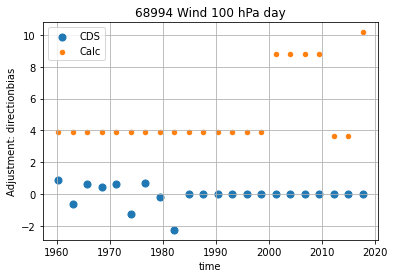

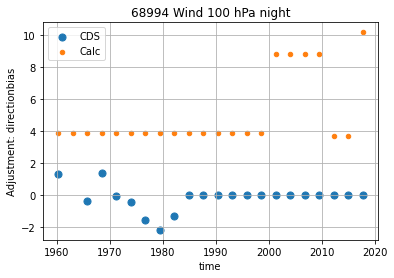

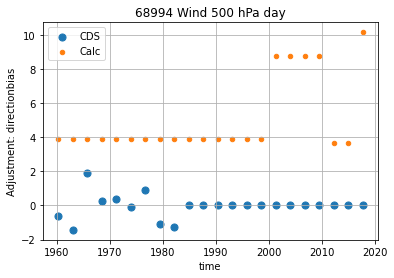

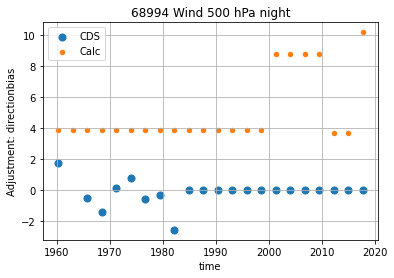

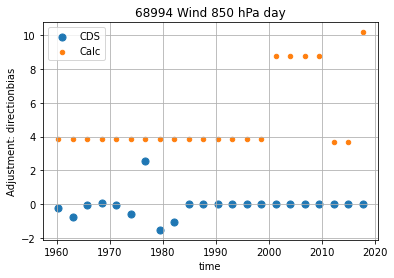

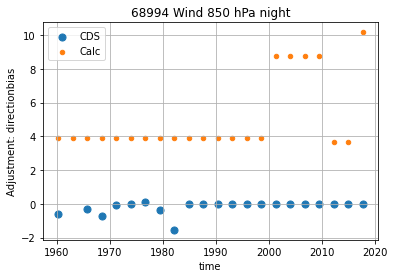

In [6]:
station = '68994'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir035229.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 17.55 MB
Filename: ./Wind_adjustment/035229/feedbackmergedwinddir035229.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 23562)
 - V | datum________________________________________ : : (23562,)
 - V | directionbias________________________________ : : (2, 16, 23562)
 - V | era5_fgdep___________________________________ : : (2, 16, 23562)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 23562)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (23562,)
 - V | uwindb

2021-05-06 08:40:42,478 INFO Welcome to the CDS
2021-05-06 08:40:42,479 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:40:42,691 INFO Request is completed
2021-05-06 08:40:42,692 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620282826.7240214-32453-1-781ddf6b-f944-44be-b4e0-6cee77712c34.zip to download.zip (10.7M)
2021-05-06 08:40:44,881 INFO Download rate 4.9M/s   
2021-05-06 08:40:44,956 INFO Reading Profile on slice(None, None, None)


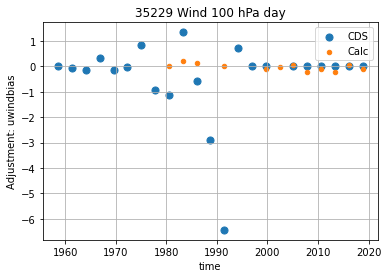

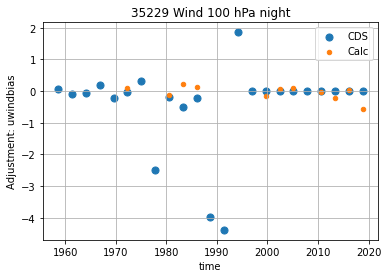

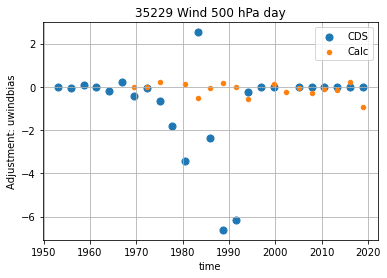

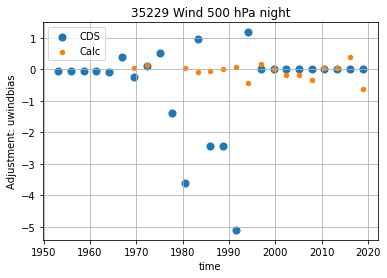

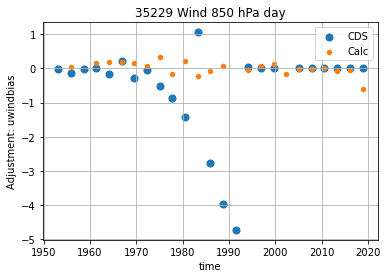

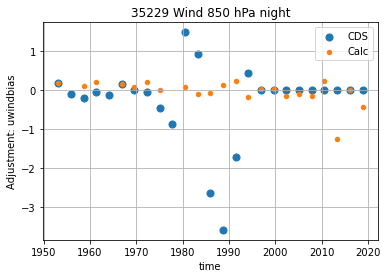

In [7]:
station = '35229'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

File: <HDF5 file "feedbackmergedwinddir035229.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 17.55 MB
Filename: ./Wind_adjustment/035229/feedbackmergedwinddir035229.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 23562)
 - V | datum________________________________________ : : (23562,)
 - V | directionbias________________________________ : : (2, 16, 23562)
 - V | era5_fgdep___________________________________ : : (2, 16, 23562)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 23562)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (23562,)
 - V | uwindb

[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:41:17,232 INFO Welcome to the CDS
2021-05-06 08:41:17,233 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 08:41:17,403 INFO Request is completed
2021-05-06 08:41:17,404 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620282843.7510743-32530-1-7fdc5233-275c-4240-956d-0545311d5735.zip to download.zip (10.7M)
2021-05-06 08:41:19,623 INFO Download rate 4.8M/s   
2021-05-06 08:41:19,756 INFO Reading Profile on slice(None, None, None)


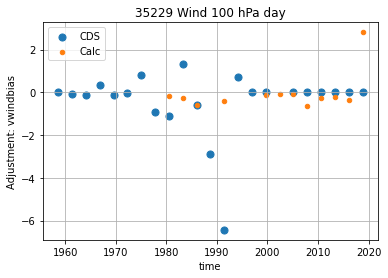

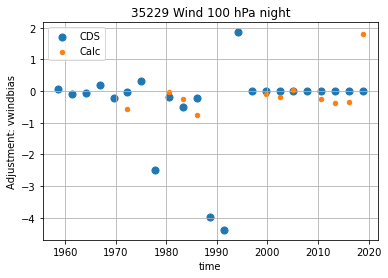

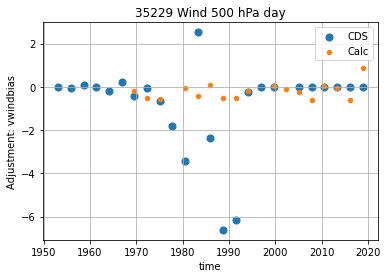

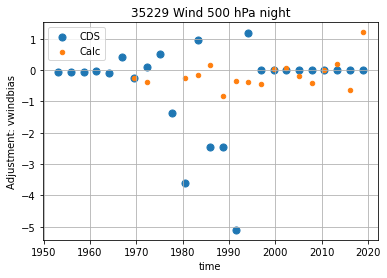

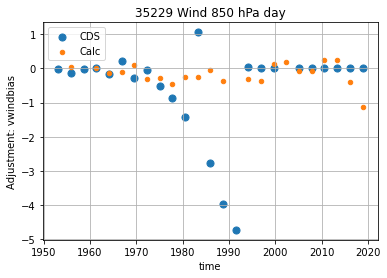

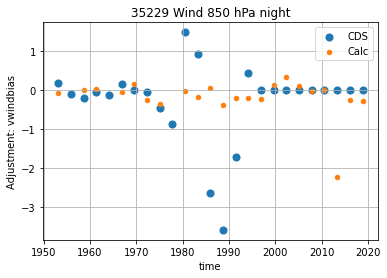

In [8]:
station = '35229'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir035229.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 17.55 MB
Filename: ./Wind_adjustment/035229/feedbackmergedwinddir035229.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 23562)
 - V | datum________________________________________ : : (23562,)
 - V | directionbias________________________________ : : (2, 16, 23562)
 - V | era5_fgdep___________________________________ : : (2, 16, 23562)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 23562)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (23562,)
 - V | uwindb

2021-05-06 08:41:37,708 INFO Welcome to the CDS
2021-05-06 08:41:37,709 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:41:37,921 INFO Request is completed
2021-05-06 08:41:37,922 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620282863.5972478-32342-1-f6d25003-a827-4f63-8d08-b0f7122d2a16.zip to download.zip (9.3M)
2021-05-06 08:41:39,933 INFO Download rate 4.6M/s   
2021-05-06 08:41:40,005 INFO Reading Profile on slice(None, None, None)


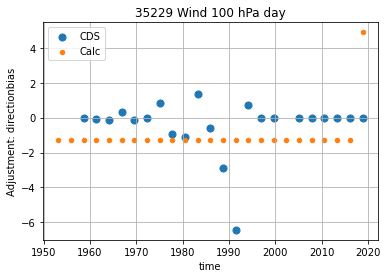

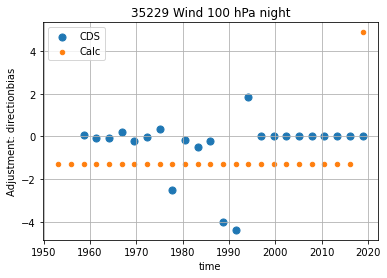

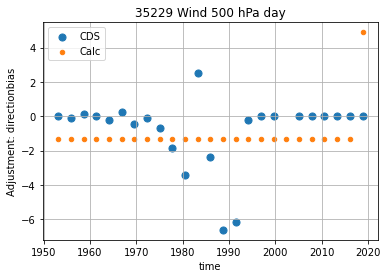

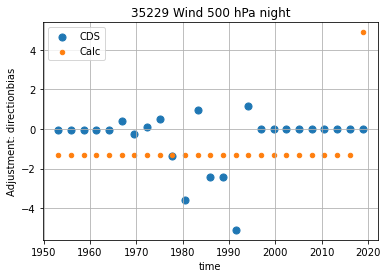

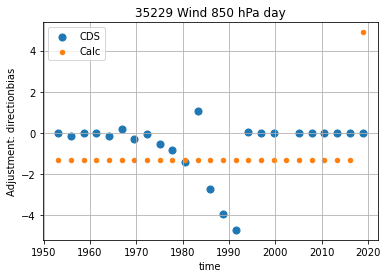

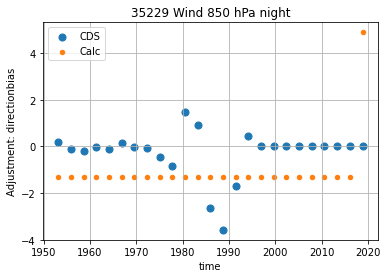

In [9]:
station = '35229'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir070219.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 20.94 MB
Filename: ./Wind_adjustment/070219/feedbackmergedwinddir070219.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 28125)
 - V | datum________________________________________ : : (28125,)
 - V | directionbias________________________________ : : (2, 16, 28125)
 - V | era5_fgdep___________________________________ : : (2, 16, 28125)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 28125)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (28125,)
 - V | uwindb

2021-05-06 08:41:58,778 INFO Welcome to the CDS
2021-05-06 08:41:58,780 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:41:58,943 INFO Request is completed
2021-05-06 08:41:58,944 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620282887.030458-32415-1-de88b8c4-4101-4784-9134-99b7be2eca3c.zip to download.zip (22.7M)
2021-05-06 08:42:03,818 INFO Download rate 4.7M/s   
2021-05-06 08:42:04,032 INFO Reading Profile on slice(None, None, None)


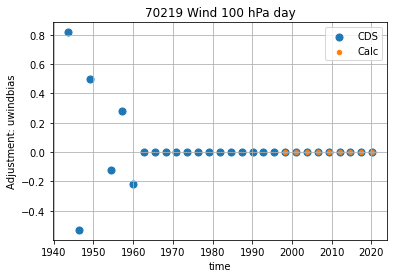

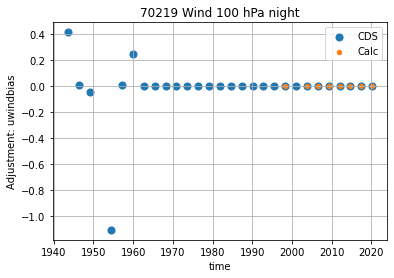

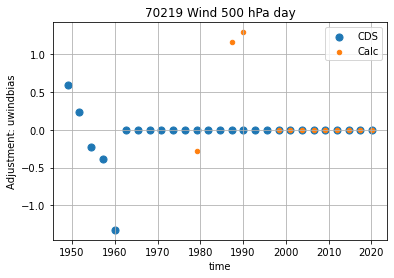

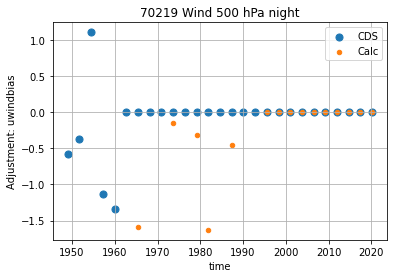

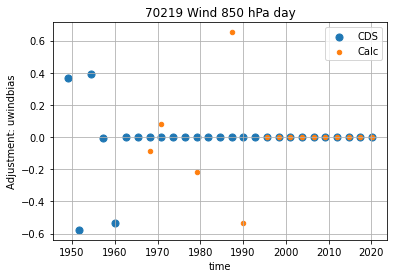

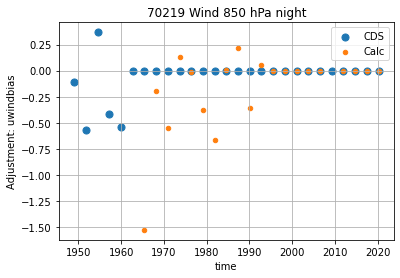

In [10]:
station = '70219'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

File: <HDF5 file "feedbackmergedwinddir070219.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 20.94 MB
Filename: ./Wind_adjustment/070219/feedbackmergedwinddir070219.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 28125)
 - V | datum________________________________________ : : (28125,)
 - V | directionbias________________________________ : : (2, 16, 28125)
 - V | era5_fgdep___________________________________ : : (2, 16, 28125)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 28125)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (28125,)
 - V | uwindb

2021-05-06 08:42:23,523 INFO Welcome to the CDS
2021-05-06 08:42:23,524 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:42:23,694 INFO Request is completed
2021-05-06 08:42:23,696 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620282923.0098147-32752-1-6206087b-80f6-4487-ab72-76fdc14a6cc9.zip to download.zip (22.7M)
2021-05-06 08:42:30,306 INFO Download rate 3.4M/s   
2021-05-06 08:42:37,268 INFO Reading Profile on slice(None, None, None)


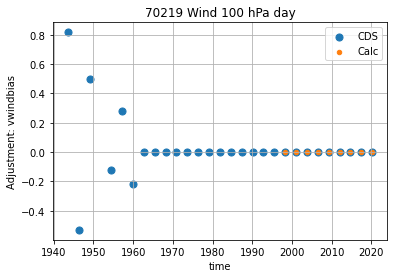

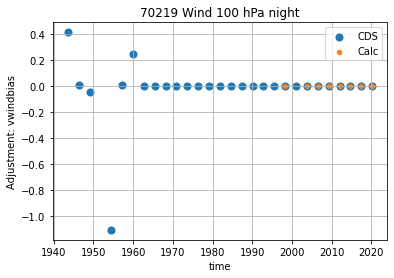

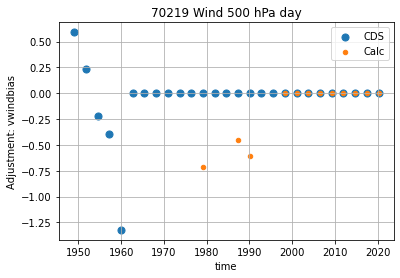

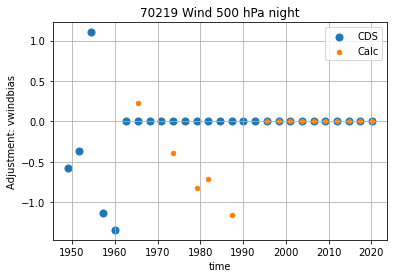

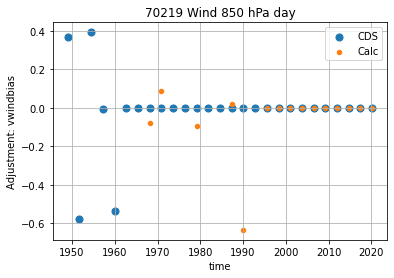

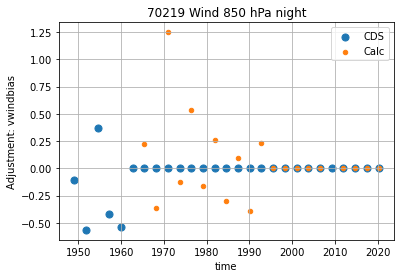

In [11]:
station = '70219'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir070219.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 20.94 MB
Filename: ./Wind_adjustment/070219/feedbackmergedwinddir070219.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 28125)
 - V | datum________________________________________ : : (28125,)
 - V | directionbias________________________________ : : (2, 16, 28125)
 - V | era5_fgdep___________________________________ : : (2, 16, 28125)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 28125)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (28125,)
 - V | uwindb

2021-05-06 08:42:57,551 INFO Welcome to the CDS
2021-05-06 08:42:57,552 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:42:57,888 INFO Request is completed
2021-05-06 08:42:57,889 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620282963.471819-309-1-b4716e38-49fc-4c26-a273-754bd50b99b9.zip to download.zip (21.9M)
2021-05-06 08:43:03,240 INFO Download rate 4.1M/s   
2021-05-06 08:43:03,383 INFO Reading Profile on slice(None, None, None)


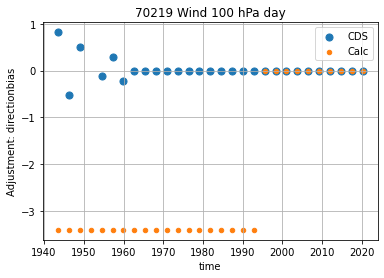

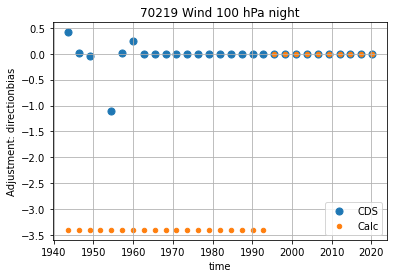

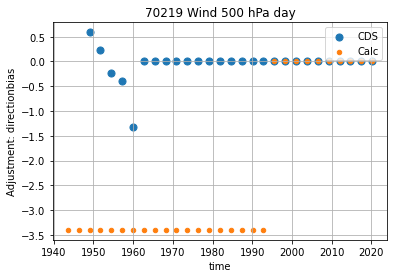

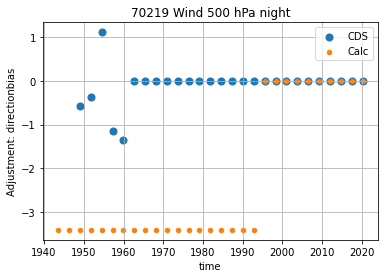

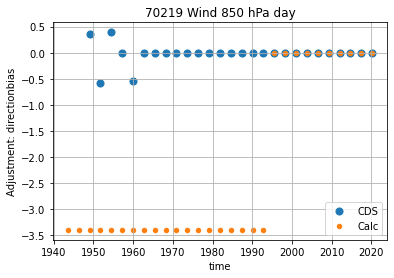

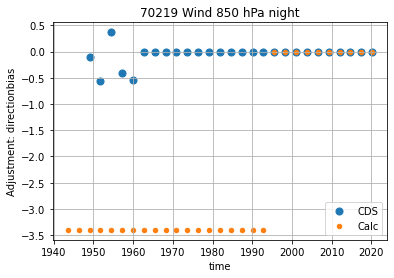

In [12]:
station = '70219'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

File: <HDF5 file "feedbackmergedwinddir010393.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 16.13 MB
Filename: ./Wind_adjustment/010393/feedbackmergedwinddir010393.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 21657)
 - V | datum________________________________________ : : (21657,)
 - V | directionbias________________________________ : : (2, 16, 21657)
 - V | era5_fgdep___________________________________ : : (2, 16, 21657)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 21657)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (21657,)
 - V | uwindb

2021-05-06 08:43:22,942 INFO Welcome to the CDS
2021-05-06 08:43:22,944 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:43:23,126 INFO Request is completed
2021-05-06 08:43:23,127 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620283009.980628-541-1-c2c8d10f-e9fa-4fb1-b8bd-d20bd8471bc1.zip to download.zip (32.3M)
2021-05-06 08:43:26,178 INFO Download rate 10.6M/s  
2021-05-06 08:43:26,390 INFO Reading Profile on slice(None, None, None)


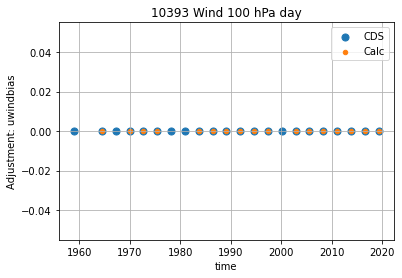

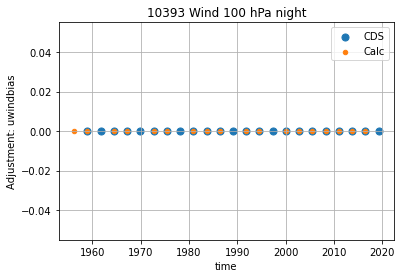

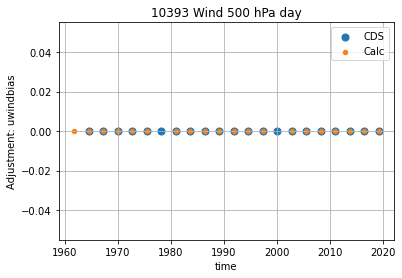

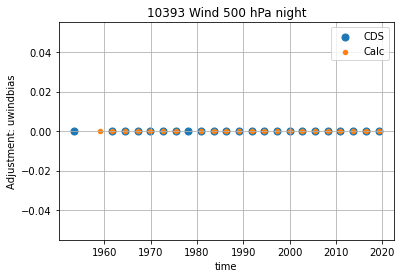

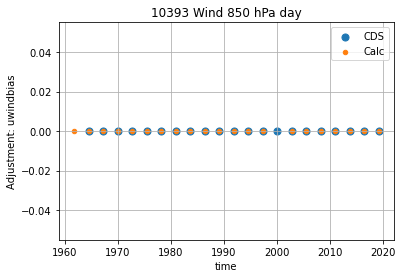

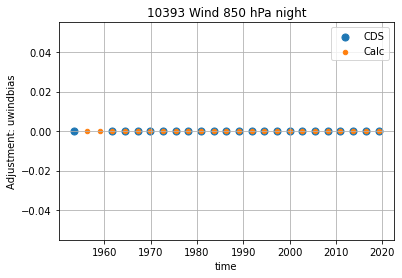

In [13]:
station = '10393'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir010393.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 16.13 MB
Filename: ./Wind_adjustment/010393/feedbackmergedwinddir010393.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 21657)
 - V | datum________________________________________ : : (21657,)
 - V | directionbias________________________________ : : (2, 16, 21657)
 - V | era5_fgdep___________________________________ : : (2, 16, 21657)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 21657)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (21657,)
 - V | uwindb

[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:44:00,212 INFO Welcome to the CDS
2021-05-06 08:44:00,213 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 08:44:00,623 INFO Request is queued
2021-05-06 08:44:01,659 INFO Request is running
2021-05-06 08:44:13,998 INFO Request is completed
2021-05-06 08:44:13,999 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620283452.6044853-608-1-96f478ab-2d01-4c9c-a9df-feb786e4bebf.zip to download.zip (32.3M)
2021-05-06 08:44:19,842 INFO Download rate 5.5M/s     
2021-05-06 08:44:20,030 INFO Reading Profile on slice(None, None, None)


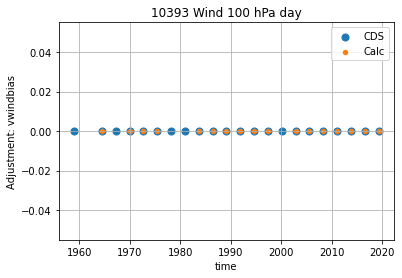

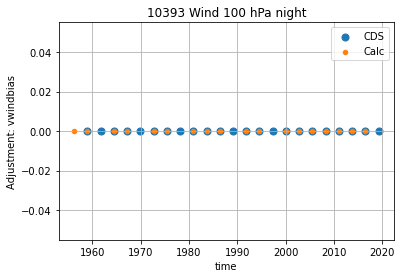

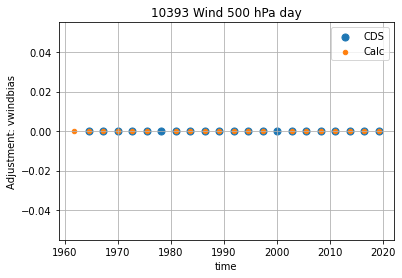

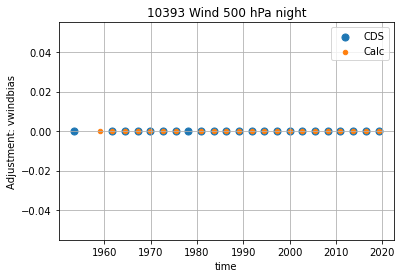

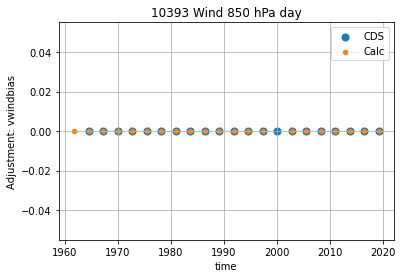

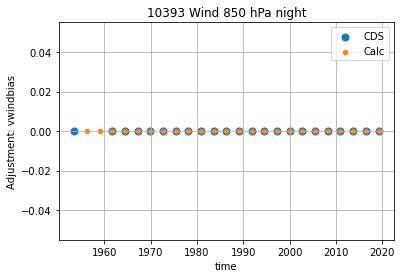

In [14]:
station = '10393'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir010393.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 16.13 MB
Filename: ./Wind_adjustment/010393/feedbackmergedwinddir010393.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 21657)
 - V | datum________________________________________ : : (21657,)
 - V | directionbias________________________________ : : (2, 16, 21657)
 - V | era5_fgdep___________________________________ : : (2, 16, 21657)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 21657)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (21657,)
 - V | uwindb

[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:44:55,734 INFO Welcome to the CDS
2021-05-06 08:44:55,735 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 08:44:56,072 INFO Request is queued
2021-05-06 08:44:57,109 INFO Request is running
2021-05-06 08:45:09,454 INFO Request is completed
2021-05-06 08:45:09,455 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620283508.1292768-475-1-3fd96ff2-e57b-406f-aae9-ba90948706dd.zip to download.zip (31.1M)
2021-05-06 08:45:21,927 INFO Download rate 2.5M/s     
2021-05-06 08:45:22,116 INFO Reading Profile on slice(None, None, None)


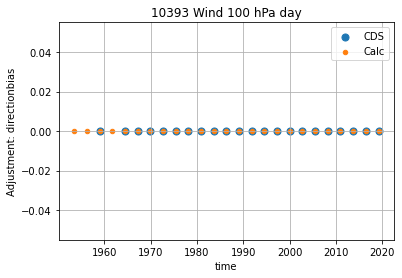

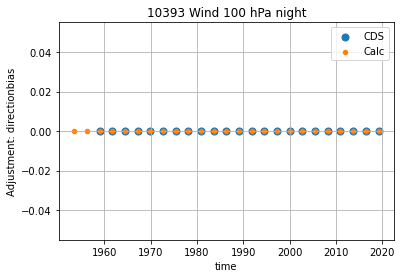

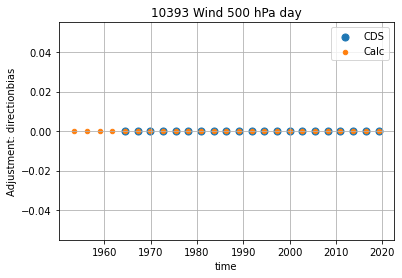

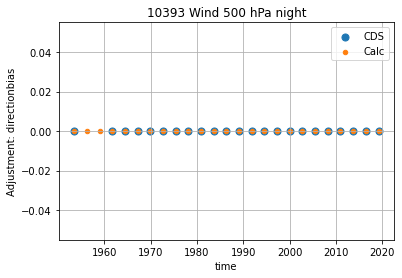

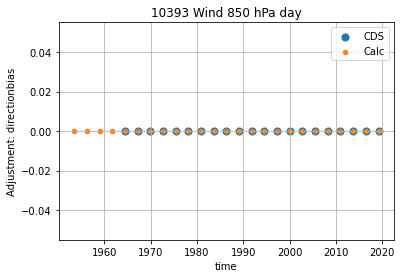

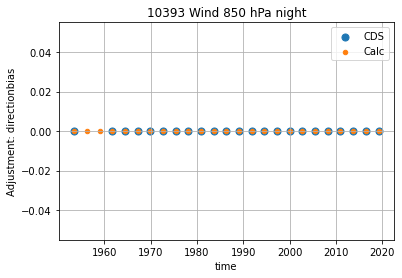

In [15]:
station = '10393'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

File: <HDF5 file "feedbackmergedwinddir011035.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 19.47 MB
Filename: ./Wind_adjustment/011035/feedbackmergedwinddir011035.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 26148)
 - V | datum________________________________________ : : (26148,)
 - V | directionbias________________________________ : : (2, 16, 26148)
 - V | era5_fgdep___________________________________ : : (2, 16, 26148)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 26148)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (26148,)
 - V | uwindb

2021-05-06 08:45:47,250 INFO Welcome to the CDS
2021-05-06 08:45:47,252 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:45:47,586 INFO Request is queued
2021-05-06 08:45:48,628 INFO Request is running
2021-05-06 08:45:52,455 INFO Request is completed
2021-05-06 08:45:52,456 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620283551.0877202-676-1-26b1221d-d91a-4838-b56d-65817086e7d0.zip to download.zip (35.8M)
2021-05-06 08:46:15,930 INFO Download rate 1.5M/s     
2021-05-06 08:46:16,204 INFO Reading Profile on slice(None, None, None)


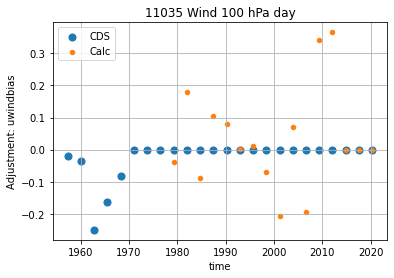

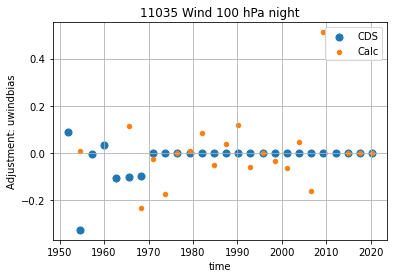

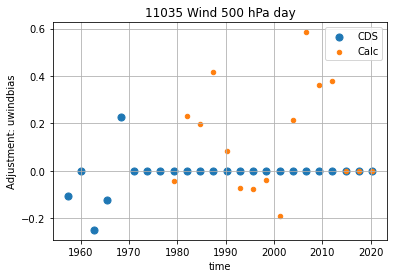

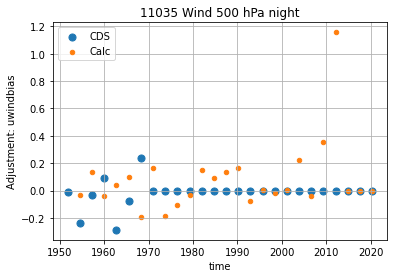

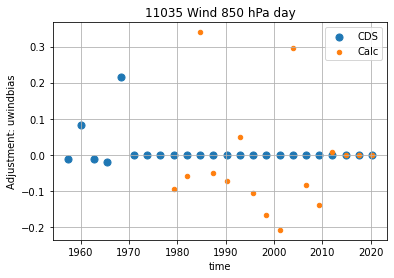

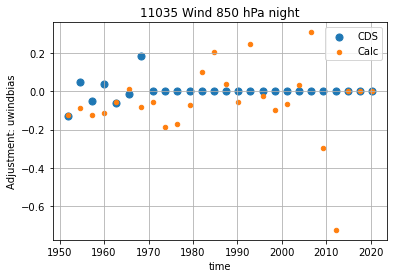

In [16]:
station = '11035'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir011035.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 19.47 MB
Filename: ./Wind_adjustment/011035/feedbackmergedwinddir011035.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 26148)
 - V | datum________________________________________ : : (26148,)
 - V | directionbias________________________________ : : (2, 16, 26148)
 - V | era5_fgdep___________________________________ : : (2, 16, 26148)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 26148)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (26148,)
 - V | uwindb

[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:46:55,814 INFO Welcome to the CDS
2021-05-06 08:46:55,815 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 08:46:56,139 INFO Request is queued
2021-05-06 08:46:57,175 INFO Request is running
2021-05-06 08:47:00,999 INFO Request is completed
2021-05-06 08:47:01,001 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620283619.6470017-746-1-42aa1fc0-85e5-4172-8815-368e6e7a7ac0.zip to download.zip (35.8M)
2021-05-06 08:47:14,547 INFO Download rate 2.6M/s   
2021-05-06 08:47:16,034 INFO Reading Profile on slice(None, None, None)


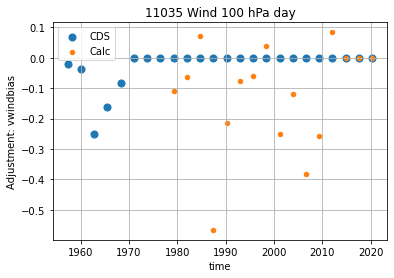

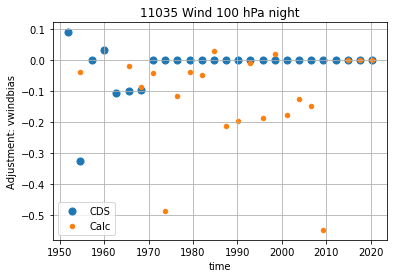

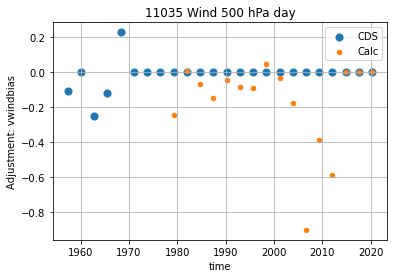

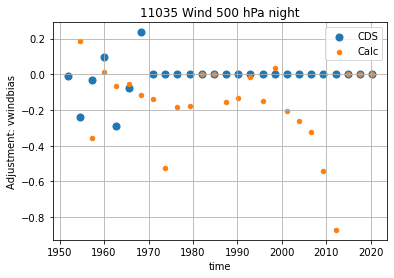

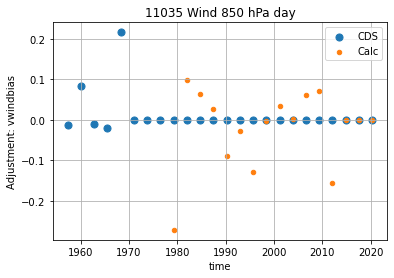

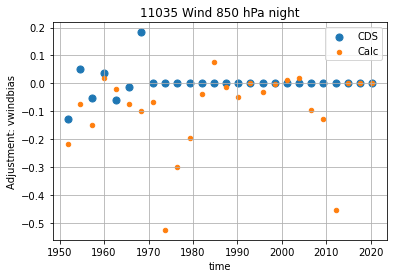

In [17]:
station = '11035'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir011035.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 19.47 MB
Filename: ./Wind_adjustment/011035/feedbackmergedwinddir011035.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 26148)
 - V | datum________________________________________ : : (26148,)
 - V | directionbias________________________________ : : (2, 16, 26148)
 - V | era5_fgdep___________________________________ : : (2, 16, 26148)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 26148)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (26148,)
 - V | uwindb

2021-05-06 08:47:43,147 INFO Welcome to the CDS
2021-05-06 08:47:43,147 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:47:43,466 INFO Request is queued
2021-05-06 08:47:44,507 INFO Request is running
2021-05-06 08:47:48,334 INFO Request is completed
2021-05-06 08:47:48,335 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620283666.741567-809-1-63dfcbc0-2f2a-4c8e-85d5-383c580d4828.zip to download.zip (34.5M)
2021-05-06 08:48:05,611 INFO Download rate 2M/s       
2021-05-06 08:48:06,305 INFO Reading Profile on slice(None, None, None)


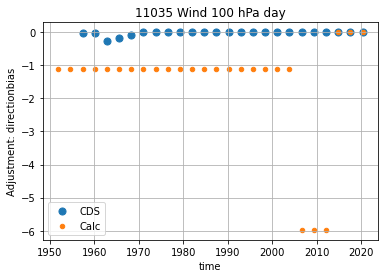

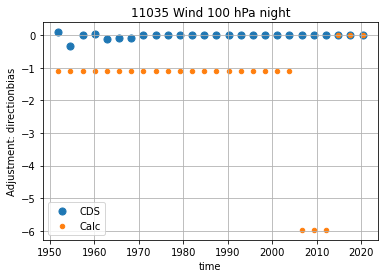

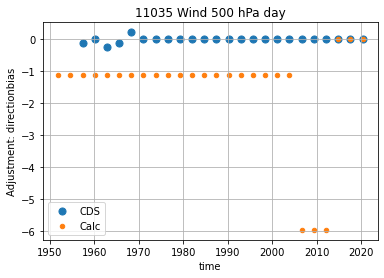

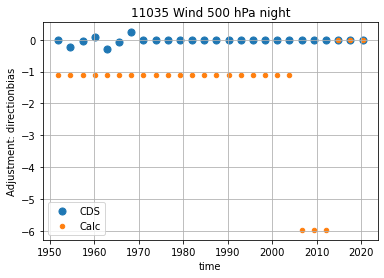

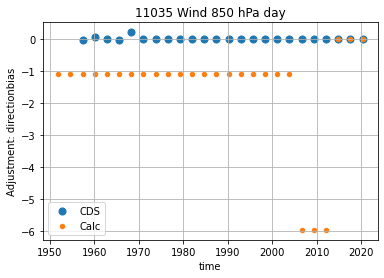

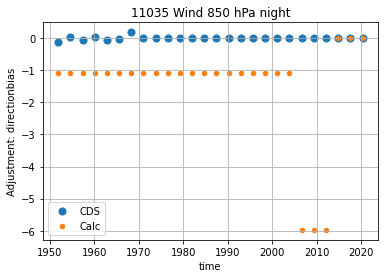

In [18]:
station = '11035'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

File: <HDF5 file "feedbackmergedwinddir091413.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 18.85 MB
Filename: ./Wind_adjustment/091413/feedbackmergedwinddir091413.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 25304)
 - V | datum________________________________________ : : (25304,)
 - V | directionbias________________________________ : : (2, 16, 25304)
 - V | era5_fgdep___________________________________ : : (2, 16, 25304)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 25304)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (25304,)
 - V | uwindb

2021-05-06 08:48:37,646 INFO Welcome to the CDS
2021-05-06 08:48:37,647 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:48:37,962 INFO Request is queued
2021-05-06 08:48:38,997 INFO Request is running
2021-05-06 08:48:40,532 INFO Request is completed
2021-05-06 08:48:40,533 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620283719.3483555-899-1-d6d0f058-cac2-4eca-9869-ae6950c159ce.zip to download.zip (27.5M)
2021-05-06 08:48:51,610 INFO Download rate 2.5M/s   
2021-05-06 08:48:53,679 INFO Reading Profile on slice(None, None, None)


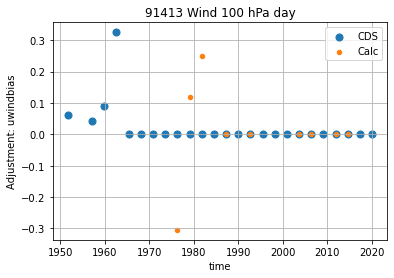

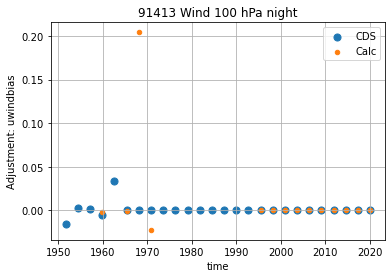

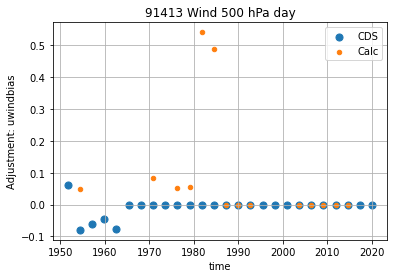

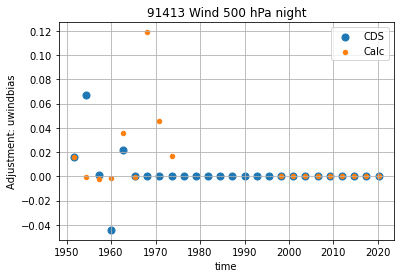

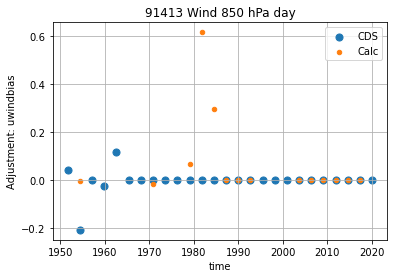

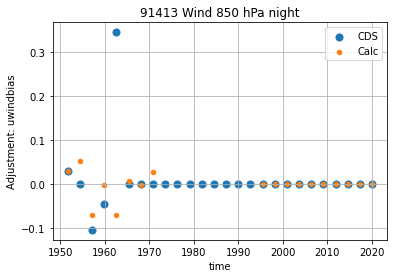

In [19]:
station = '91413'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir091413.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 18.85 MB
Filename: ./Wind_adjustment/091413/feedbackmergedwinddir091413.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 25304)
 - V | datum________________________________________ : : (25304,)
 - V | directionbias________________________________ : : (2, 16, 25304)
 - V | era5_fgdep___________________________________ : : (2, 16, 25304)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 25304)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (25304,)
 - V | uwindb

2021-05-06 08:49:14,054 INFO Welcome to the CDS
2021-05-06 08:49:14,055 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:49:14,216 INFO Request is queued
2021-05-06 08:49:15,253 INFO Request is running
2021-05-06 08:49:16,792 INFO Request is completed
2021-05-06 08:49:16,794 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620283755.5360098-858-1-c92c3e64-8ca0-440a-9610-58b47762c506.zip to download.zip (27.6M)
2021-05-06 08:49:35,906 INFO Download rate 1.4M/s   
2021-05-06 08:49:36,127 INFO Reading Profile on slice(None, None, None)


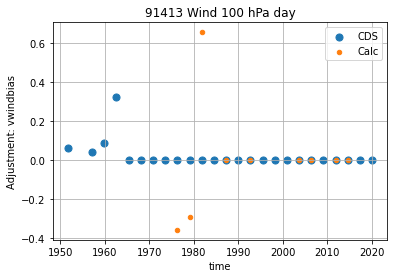

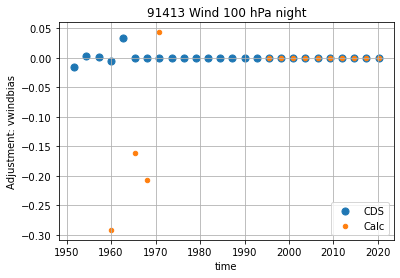

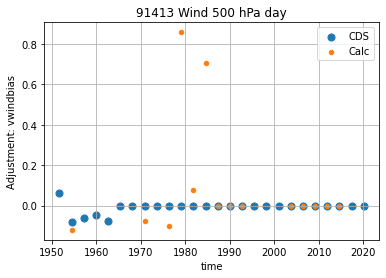

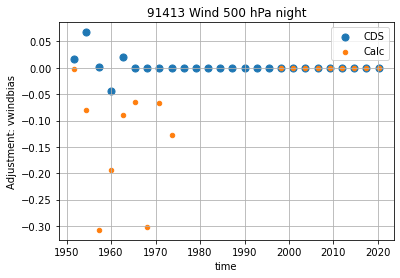

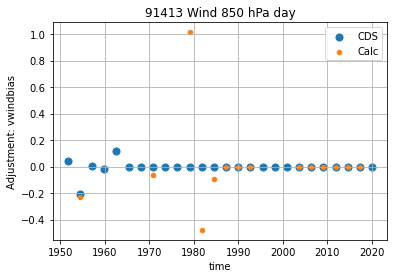

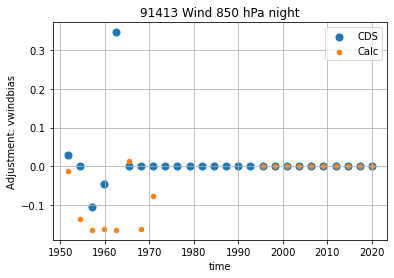

In [20]:
station = '91413'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir091413.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 18.85 MB
Filename: ./Wind_adjustment/091413/feedbackmergedwinddir091413.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 25304)
 - V | datum________________________________________ : : (25304,)
 - V | directionbias________________________________ : : (2, 16, 25304)
 - V | era5_fgdep___________________________________ : : (2, 16, 25304)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 25304)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (25304,)
 - V | uwindb

[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-06 08:49:55,737 INFO Welcome to the CDS
2021-05-06 08:49:55,738 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-06 08:49:56,055 INFO Request is queued
2021-05-06 08:49:57,097 INFO Request is running
2021-05-06 08:49:58,637 INFO Request is completed
2021-05-06 08:49:58,639 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620283797.3935905-980-1-a004764b-f1da-465d-9d90-9e8e1ebb67d8.zip to download.zip (27M)
2021-05-06 08:50:14,620 INFO Download rate 1.7M/s   
2021-05-06 08:50:14,897 INFO Reading Profile on slice(None, None, None)


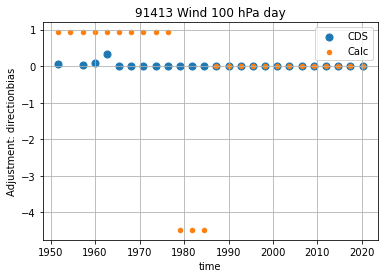

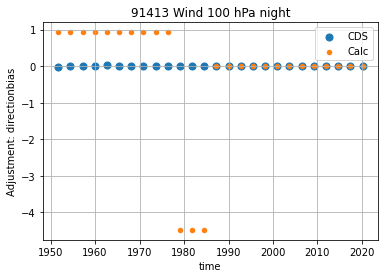

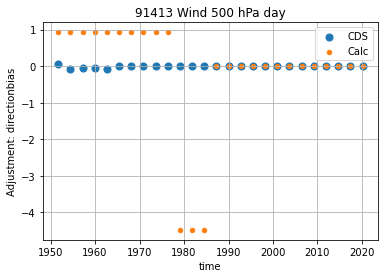

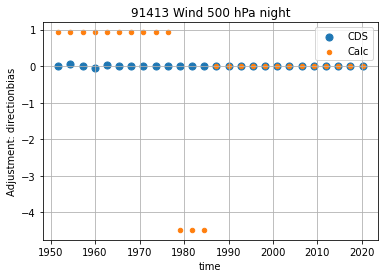

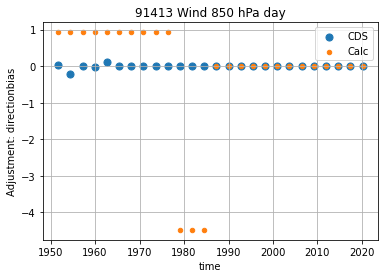

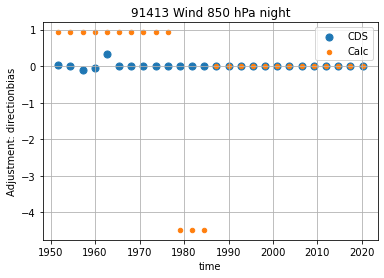

In [21]:
station = '91413'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)